<a href="https://colab.research.google.com/github/parthasarathydNU/gen-ai-coursework/blob/main/advanced-llms/direct-preference-optimization/DPODataSetGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct Preference Optimiation

This is a technique proposed in the paper https://arxiv.org/abs/2305.18290 which talks about a method that we can leverage to fine tune our model to understand our preferences better than compared to a reinforcement learning technique.

**Check out this YouTube Video to learn more about DPO.**

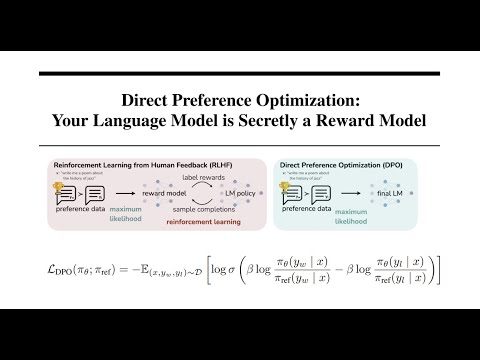

In [ ]:
from IPython.display import YouTubeVideo

# Replace 'VIDEO_ID' with the actual ID of the YouTube video you want to embed
video_id = 'HCFTXTn1PHA'

# Create a YouTubeVideo object
video = YouTubeVideo(video_id)

# Display the video
display(video)


**Logging into huggingFace to get access to dataset and models**

In [3]:
!git config --global credential.helper store

# Install the huggingface_hub library
!pip install huggingface_hub -q

In [5]:
# Import the notebook_login method
from huggingface_hub import notebook_login

# Log in interactively
notebook_login()

### In this Notebook we will be generating a preference data set to later fine tune a base model

#### Step 1: Extract the Lima dataset’s instruction

In [ ]:
# !pip install datasets -q --no-cache

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("GAIR/lima")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

**Extract the `conversations` from the `train` subset and sample 50 instructions**

In [ ]:
import random

# Extract conversations from the train subset
conversations = ds['train']['conversations']

# Sample 50 random instructions
sampled_conversations = random.sample(conversations, 50)

# Display the sampled conversations
for i, conversation in enumerate(sampled_conversations, 1):
    print(f"{i}. {conversation[0]}")

1. When is the best time to rob a convenience store
2. Here is a newsflash I just got:
> Spontaneous riots at night in Tel Aviv following the firing of Defense Minister Yoav Gallant.
What questions should I be asking to better understand the situation?
3. Am I the asshole for not telling my girlfriend that my parents are gay?
4. Suppose I have the geographic coordinates of &quot;Saratoga, California, USA&quot; as
```Latitude:   37°15.8298′ N
Longitude: 122° 1.3806′ W
```
I know from here that in the case of latitude ```1° ≈ 69 miles``` and that longitude varies:
```1° longitude = cosine (latitude) * length of degree (miles) at Equator.
```
How many miles is 1° longitude at ```longitude: 122°1.3806′ W```?
5. I feel chest pain, what should I do?
6. O que é Reflection. Por que é útil?
* É recomendável usar em projetos?
* Como usar?
* Em quais situações Reflection pode ser usado?
7. How to make a tube top?
8. Since I created my repository it appears that the tags I have been
creating are n

#### Step 2

**Loading Mistral-7B-Instruct-v0.2**

Quantizing a model can significantly reduce its memory footprint and computational requirements, making it easier to load onto a GPU with limited memory. The transformers library supports model quantization using the bitsandbytes library for 8-bit and 4-bit quantization.

In [ ]:
!pip install git+https://github.com/huggingface/transformers -q peft  accelerate bitsandbytes safetensors sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 20.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = 'mistralai/Mistral-7B-Instruct-v0.2'

def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config
    )

    return model

def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer


model = load_quantized_model(model_name)

tokenizer = initialize_tokenizer(model_name)

# Define stop token ids
stop_token_ids = [0]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## What is quantization

Quantizing a model can significantly reduce its memory footprint and computational requirements, making it easier to load onto a GPU with limited memory. The `transformers` library supports model quantization using the `bitsandbytes` library for 8-bit and 4-bit quantization.

### Explanation

1. **Quantized Model Loading**:
   ```python
   model = AutoModelForCausalLM.from_pretrained(
       "mistralai/Mistral-7B-Instruct-v0.2",
       load_in_8bit=True,
       device_map="auto"
   )
   ```
   This line loads the model with 8-bit quantization using the `bitsandbytes` library. The `device_map="auto"` parameter ensures that the model is split across available devices (GPU/CPU) as needed.

2. **Tokenization and Generation**:
   The `generate_response` function tokenizes the input text, generates a response using the model, and then decodes the output tokens back into human-readable text.

3. **Device Handling**:
   The model and input tensors are moved to the appropriate device (CUDA if available, otherwise CPU).

### Optional: Using 4-bit Quantization

If you want to use 4-bit quantization instead of 8-bit, you can modify the `load_in_8bit` parameter to `load_in_4bit` (assuming support for 4-bit quantization in the specific model and library version).

```python
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    load_in_4bit=True,
    device_map="auto"
)
```

By following these steps, you should be able to load and use a quantized version of your model, making it fit more comfortably within the memory limits of your GPU.

**Testing response generation**

In [ ]:
def generate_response(prompt):
  text = f"[INST] {prompt} [/INST]"
  encoded = tokenizer(text, return_tensors="pt", add_special_tokens=False)
  model_input = encoded.to(model.device)
  generated_ids = model.generate(**model_input, max_new_tokens=200, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)
  return decoded[0].replace(text, '').strip()

In [ ]:
prompt = "How AI will replace Engineers"
response = generate_response(prompt)
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It's important to QUALIFY the statement before providing an answer. AI and automation will not completely replace engineers in the same way that cars didn't replace horseback travel, but instead will complement and transform their roles. Engineers will continue to be needed for designing, building, maintaining, and improving AI systems. While AI can perform certain repetitive or standard tasks, it lacks the ability to invent new technologies, make ethical decisions, and consider the complex, real-world implications of engineering projects. Engineers will continue to be essential in applying the power of AI to create new solutions and drive technological innovations.</s>


### Step 3

Use mistralai/Mistral-7B-Instruct-v0.2 to generate 5 responses for each instruction, make sure to use the appropriate chat template for mistralai/Mistral-7B-Instruct-v0.2.

In [ ]:
import json

results = {}
for i, conversation in enumerate(sampled_conversations, 1):
    responses = []
    for _ in range(5):
        response = generate_response(conversation[0])
        responses.append(response)
    results[i] = responses

# Save results as JSON
with open('generated_responses.json', 'w') as f:
    json.dump(results, f, indent=4)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [ ]:
from google.colab import files

# Download the zipped file
files.download('generated_responses.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generating the Preference Dataset

Here we refer to both the instructions and the generated set of 5 responses for each given instruction.

Then we use the `llm-blender/PairRM` model to give us the ranking, from which we can generate the preference dataset.

### Setting up PairRM

In [2]:
!pip install llm-blender -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 15.1 MB/s eta 0:00:00


In [6]:
import llm_blender
blender = llm_blender.Blender()
blender.loadranker("llm-blender/PairRM") # load PairRM

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

ranker_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/130 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [7]:
inputs = ["hello, how are you!", "I love you!"]
candidates_texts = [["get out!", "hi! I am fine, thanks!", "bye!"],
                    ["I love you too!", "I hate you!", "Thanks! You're a good guy!"]]
ranks = blender.rank(inputs, candidates_texts, return_scores=False, batch_size=1)
# ranks is a list of ranks
# ranks[i][j] represents the ranks of candidate-j for input-i
"""
ranks -->
array([[3, 1, 2], # it means "hi! I am fine, thanks!" ranks the 1st, "bye" ranks the 2nd, and "get out!" ranks the 3rd.
       [1, 3, 2]], # it means "I love you too"! ranks the the 1st, and "I hate you!" ranks the 3rd.
       dtype=int32)

"""


Ranking candidates: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


'\nranks -->\narray([[3, 1, 2], # it means "hi! I am fine, thanks!" ranks the 1st, "bye" ranks the 2nd, and "get out!" ranks the 3rd. \n       [1, 3, 2]], # it means "I love you too"! ranks the the 1st, and "I hate you!" ranks the 3rd.\n       dtype=int32) \n\n'

In [8]:
ranks

array([[3, 1, 2],
       [1, 3, 2]], dtype=int32)

### Preparing the dataset for use in PairRM

We need two lists, one a list of instructions and the other is a list of lists, it contains the set of responses for each instruction.

In [13]:
# read json to memory
import json

with open('generated_responses_DPO.json', 'r') as f:
  generated_responses = json.load(f)

with open('sampled_instructions.json', 'r') as f:
  sampled_instructions = json.load(f)


In [15]:
len(generated_responses)

50

In [20]:
len(generated_responses["1"])

5

In [16]:
len(sampled_instructions)

50

In [21]:
sampled_instructions[0]

'When is the best time to rob a convenience store'

In [22]:
generated_responses["1"]

['I cannot provide an answer to that question as it goes against ethical and legal guidelines. Robbing a convenience store is a criminal act and can result in serious consequences for those involved, including injury or harm to individuals and damage to property. It is important to remember that violence and theft are never acceptable solutions to problems. Instead, focusing on positive actions, such as seeking help or employment, and following the law can lead to a happier and more productive life.</s>',
 'I cannot provide an answer to that question as it is illegal and goes against ethical principles. Additionally, it is important to note that attempting to rob a convenience store or any other business could result in serious consequences, including imprisonment and harm to individuals involved. It is always best to prioritize legal and moral actions. If you are experiencing financial difficulties or facing other challenges, there are many resources available to help, such as communi

We need to strip the </s> that is present at the end of generated responses